In [8]:
from dataclasses import dataclass
import time
from tqdm import tqdm
from multiprocessing import Pool
from sklearn import preprocessing

from matplotlib.patches import FancyBboxPatch
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MultipleLocator, FormatStrFormatter,FuncFormatter
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, HourLocator, MinuteLocator, SecondLocator, DateFormatter
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from matplotlib.legend_handler import HandlerPathCollection
from matplotlib.lines import Line2D
import matplotlib.patheffects as path_effects
from matplotlib.patches import Patch
from matplotlib.transforms import offset_copy

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mpltern

import obspy as op
from obspy import read,read_inventory, UTCDateTime, Stream, Trace
from obspy.clients.fdsn.client import Client
from obspy.signal.rotate import rotate_ne_rt
from obspy.geodetics import gps2dist_azimuth,kilometers2degrees
from obspy.taup import TauPyModel

import json
import glob
import os
import numpy as np
from itertools import combinations
import pandas as pd
from scipy.signal import spectrogram, detrend, resample,savgol_filter,decimate,hilbert
from scipy.stats import circmean, circstd,gaussian_kde
from kneed import KneeLocator
import math
import pyarrow.feather as feather

import datetime

from sklearn.linear_model import LinearRegression,HuberRegressor,TheilSenRegressor
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
from sklearn.metrics import silhouette_score

In [9]:
# ===========
# DIRECTORIES
# ===========

## ------------------------
## Directory of the catalog (.CSV file of the National Earthquake Information Center (NEIC))
## The file layout is defined as:
## time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource

#XML_DIR = '/home/sysop/dados_posdoc/PROJETO_RSBR_15_YEARS/XML/'
#XML_DIR = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/RSBR_15_years/XML/'
XML_DIR = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/RSBR_15_years/Artigo_SSPARQ/XML/'

## -----------------------
## Directory of the output (Figures and Feathers file)

#ORIENTATION_OUTPUT = '/home/sysop/dados_posdoc/PROJETO_RSBR_15_YEARS/OUTPUT/'
#ORIENTATION_OUTPUT = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/RSBR_15_years/OUTPUT/'
ORIENTATION_OUTPUT = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/RSBR_15_years/Artigo_SSPARQ/OUTPUT/'

# ==========
# PARAMETERS
# ==========

## -------------------------------------------------------------------
## Apply band-pass filtering to the seismograms using the range above:

PERIOD_BANDS = [0.02,0.5]

## ===================================================================================
## Default parameters to define the signal and noise windows used to estimate the SNR:

## ------------------------------------------------------------------------------
## Duration of the signal window before and after the P-wave arrival (in seconds)

TIME_WINDOW = 60

## -----------------------------------------------------------------------------
## Start time of the P-wave window for events (in seconds before P-wave arrival)

TIME_START_P_REGIONAL = 3

## -----------------------------------------------------------------------------------
## End time of the P-wave window for regional events (in seconds after P-wave arrival)

TIME_FINAL_P_REGIONAL = 12

## ---------------------------------------------
## Minimum earthquake magnitude to be considered

minmagnitude = 6

## -------------------------------------------------------------------------------------
## Minimum and maximum epicentral distance in degrees (GCARC: great-circle arc distance)

GCARC_MIN = 5
GCARC_MAX = 100

## -----------------
## Region parameters

LLCRNRLON_LARGE = -50
URCRNRLON_LARGE = -38
LLCRNRLAT_LARGE = -30
URCRNRLAT_LARGE = -12

## ---------
## Constants

ONEDAY = datetime.timedelta(days=1)

## ---------------
## MULTIPROCESSING

num_processes = 20

## --------------------------------------
## Generate a figure for each estimation?

VERBOSE = True

In [10]:
# Formatar os rótulos do eixo Y para exibir o símbolo de graus
def format_y_ticks(value, _):
    return f"{value:.0f}°"

In [11]:
def calculate_quartis_mask(orientations):
    # Estimating quartis
    Q1 = np.percentile(orientations, 25)
    Q3 = np.percentile(orientations, 75)
    IQR = Q3 - Q1
                            
    # Defining limits
    lower_bound = Q1 - 1 * IQR
    upper_bound = Q3 + 1 * IQR
    
    # Filter mask
    mask_good = (orientations >= lower_bound) & (orientations <= upper_bound)
    mask_outliers = ~mask_good  # Inverse

    return mask_good,mask_outliers

In [12]:
colnames = ['network', 'station', 'stla', 'stlo', 'evname', 'evla', 'evlo','evtime', 'evmag', 'evtype', 'evdp', 'distance', 'gcarc', 'baz','SNR', 'phi', 'theta','clock_error', 'quality', 'gain_HHN', 'gain_HHE', 'gain_HHZ','event_class']

In [6]:
STATION_LST = sorted([i.split('/')[-1].split('.')[:2] for i in glob.glob(XML_DIR+'*US*')])

In [7]:
STATION_LST

[]

In [30]:
feather_files_lst = []

colnames = ['network', 'station','stla','stlo','evtime','evla','evlo','gcarc','evmag','baz','SNR', 'phi', 'theta','clock_error', 'quality', 'gain_HHN', 'gain_HHE', 'gain_HHZ','event_class']
    
feather_files_lst.append(pd.concat([pd.read_feather(i,columns=colnames) for i in glob.glob(ORIENTATION_OUTPUT+'FEATHER_FILES/*US*/*')]))

In [31]:
station_df = pd.concat(feather_files_lst)

In [32]:
station_df.sort_values('evtime')

,network,station,stla,stlo,evtime,evla,evlo,gcarc,evmag,baz,SNR,phi,theta,clock_error,quality,gain_HHN,gain_HHE,gain_HHZ,event_class
0,US,MVCO,37.19956,-108.49251,2006-04-20 23:34:53.635016,60.89,167.05,55.688059,7.58,323.999051,7.4,119,-155,-24.0,bad,399.563320,206.374937,681.906738,SS-N
0,US,MVCO,37.19956,-108.49251,2006-04-21 04:42:24.988824,60.50,165.98,56.303323,6.13,323.728273,15.3,298,26,1.2,good,918.275030,517.858807,1580.092421,SS
0,US,MVCO,37.19956,-108.49251,2006-04-21 11:23:52.862250,61.27,167.64,55.309476,6.03,324.349828,22.8,301,23,-3.2,good,1147.405545,578.868700,1800.261409,R-SS
0,US,MVCO,37.19956,-108.49251,2006-04-29 17:07:48.218939,60.51,167.60,55.532863,6.58,323.465862,29.1,297,26,-5.5,good,2300.267268,1337.895266,3947.777624,R-SS
0,US,MVCO,37.19956,-108.49251,2006-04-30 08:30:43.822123,-15.13,167.29,94.567719,6.09,254.654851,-11.6,247,8,38.2,bad,103.350272,82.603220,101.284210,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,US,MVCO,37.19956,-108.49251,2024-12-13 23:50:20.659997,-35.36,-70.80,80.291538,6.37,149.504142,14.2,129,21,-3.8,good,2679.893274,1221.510547,3975.296735,N
0,US,MVCO,37.19956,-108.49251,2024-12-21 15:44:16.968882,-17.74,167.92,95.655355,6.10,252.205332,-10.8,263,-11,-65.9,bad,516.356515,504.976207,214.469609,SS-N
0,US,MVCO,37.19956,-108.49251,2024-12-27 12:58:36.538482,47.09,151.46,69.797556,6.79,314.335498,16.6,314,0,29.9,good,1217.557319,243.882628,2639.816801,N
0,US,MVCO,37.19956,-108.49251,2025-01-05 17:24:50.733116,13.06,-89.13,29.641433,6.17,139.165649,8.4,352,148,-40.4,bad,727.587146,713.088691,508.874820,SS-N


In [33]:
station_df['year_month'] = station_df['evtime'].dt.to_period('M').astype(str)
station_df['year_month'] = pd.to_datetime(station_df['year_month'], format='%Y-%m').dt.to_period('M')


In [34]:
station_df.sort_values('year_month')

,network,station,stla,stlo,evtime,evla,evlo,gcarc,evmag,baz,SNR,phi,theta,clock_error,quality,gain_HHN,gain_HHE,gain_HHZ,event_class,year_month
0,US,MVCO,37.19956,-108.49251,2006-04-20 23:34:53.635016,60.89,167.05,55.688059,7.58,323.999051,7.4,119,-155,-24.0,bad,399.563320,206.374937,681.906738,SS-N,2006-04
0,US,MVCO,37.19956,-108.49251,2006-04-30 19:28:53.844380,-27.17,-71.52,72.904966,6.60,145.861076,25.2,131,15,-4.8,good,1416.184524,151.862436,3128.917692,R,2006-04
0,US,MVCO,37.19956,-108.49251,2006-04-21 11:23:52.862250,61.27,167.64,55.309476,6.03,324.349828,22.8,301,23,-3.2,good,1147.405545,578.868700,1800.261409,R-SS,2006-04
0,US,MVCO,37.19956,-108.49251,2006-04-21 04:42:24.988824,60.50,165.98,56.303323,6.13,323.728273,15.3,298,26,1.2,good,918.275030,517.858807,1580.092421,SS,2006-04
0,US,MVCO,37.19956,-108.49251,2006-04-29 17:07:48.218939,60.51,167.60,55.532863,6.58,323.465862,29.1,297,26,-5.5,good,2300.267268,1337.895266,3947.777624,R-SS,2006-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,US,MVCO,37.19956,-108.49251,2024-12-09 00:47:50.578516,50.93,-177.38,49.562904,6.07,309.252747,8.7,349,-40,34.9,bad,1974.583862,1726.254729,3687.311806,SS-N,2024-12
0,US,MVCO,37.19956,-108.49251,2024-12-13 23:50:20.659997,-35.36,-70.80,80.291538,6.37,149.504142,14.2,129,21,-3.8,good,2679.893274,1221.510547,3975.296735,N,2024-12
0,US,MVCO,37.19956,-108.49251,2024-12-21 15:44:16.968882,-17.74,167.92,95.655355,6.10,252.205332,-10.8,263,-11,-65.9,bad,516.356515,504.976207,214.469609,SS-N,2024-12
0,US,MVCO,37.19956,-108.49251,2025-01-05 17:24:50.733116,13.06,-89.13,29.641433,6.17,139.165649,8.4,352,148,-40.4,bad,727.587146,713.088691,508.874820,SS-N,2025-01


In [37]:
# Creating mounth range datetime (timestamp) Periods
years = pd.period_range(start=station_df['year_month'].min(), end=station_df['year_month'].max(), freq='M')

In [ ]:
plt.rcParams.update({'font.size': 10})  # Define o tamanho global da fonte

fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(1,1)

ax1 = fig.add_subplot(gs[:], projection=ccrs.Mollweide())

ax2 = inset_axes(ax1, width=2, height=0.75,bbox_to_anchor=(0.2, 1.),bbox_transform=ax1.transAxes, loc="center", borderpad=0)
ax3 = inset_axes(ax1, width=2, height=0.75,bbox_to_anchor=(0.4, 1.),bbox_transform=ax1.transAxes, loc="center", borderpad=0)
ax4 = inset_axes(ax1, width=2, height=0.75,bbox_to_anchor=(0.6, 1.),bbox_transform=ax1.transAxes, loc="center", borderpad=0)
ax5 = inset_axes(ax1, width=2, height=0.75,bbox_to_anchor=(0.8, 1.),bbox_transform=ax1.transAxes, loc="center", borderpad=0)

color_sta = ['darkorange','darkgreen','darkblue']

for cs,sta in zip(color_sta,station_df['station'].unique()):
    df_sta = station_df[station_df['station'] == sta]

    ax1.text(0.05,0.9,'a)', fontsize=14, verticalalignment='center', horizontalalignment='center',transform=ax1.transAxes)


    for lon, lat in zip(df_sta['stlo'].unique(),df_sta['stla'].unique()):
    	ax1.plot(lon, lat, '^',markersize=10,markeredgecolor='k',markerfacecolor=cs, transform=ccrs.Geodetic())
    
    for lon, lat in zip(df_sta['evlo'].values,df_sta['evla'].values):
    	ax1.plot(lon, lat, '*',markersize=6,markeredgecolor='k',markerfacecolor=cs, transform=ccrs.Geodetic(),alpha=0.5)

    # Use the cartopy interface to create a matplotlib transform object
    # for the Geodetic coordinate system. We will use this along with
    # matplotlib's offset_copy function to define a coordinate system which
    # translates the text by 25 pixels to the left.
    geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax1)
    text_transform = offset_copy(geodetic_transform, units='dots', x=5,y=50)

    for lon, lat, net_n,sta_n in zip(df_sta['stlo'].unique(),df_sta['stla'].unique(),df_sta['network'].unique(),df_sta['station'].unique()):
        ax1.text(lon, lat,net_n+'.'+sta_n, verticalalignment='center', horizontalalignment='center',transform=text_transform,bbox=dict(facecolor='w', alpha=0.5, boxstyle='round'))

    # draw coastlines and borders
    ax1.stock_img()
    ax1.add_feature(cfeature.LAND)
    ax1.add_feature(cfeature.COASTLINE)
    ax1.add_feature(cfeature.BORDERS, lw=0.5)
    
    #############
    ax2.hist(df_sta['gcarc'].values,bins=50,orientation='vertical',color=cs,alpha=0.5)
    ax2.set_title("DIST",y=0.5)
    ax2.text(0.1,0.85,'b)', fontsize=14, verticalalignment='center', horizontalalignment='center',transform=ax2.transAxes)
    ax2.tick_params(axis="x", which='both', labelbottom=False, labeltop=True,top=True, rotation=30)
    ax2.set_ylim(0,200)

    #############
    ax3.hist(df_sta['SNR'].values,bins=50,orientation='vertical',color=cs,alpha=0.5)
    ax3.set_title("SNR",y=0.5)
    ax3.text(0.1,0.85,'c)', fontsize=14, verticalalignment='center', horizontalalignment='center',transform=ax3.transAxes)
    ax3.tick_params(axis="x", which='both', labelbottom=False, labeltop=True,top=True, rotation=30)
    ax3.set_ylim(0,200)
    
    #############
    ax4.hist(df_sta['evmag'].values,bins=50,orientation='vertical',color=cs,alpha=0.5) 
    ax4.set_title("MAG",y=0.5)
    ax4.set_xlim(5.5,9)
    ax4.set_ylim(0,200)
    ax4.text(0.1,0.85,'d)', fontsize=14, verticalalignment='center', horizontalalignment='center',transform=ax4.transAxes)
    ax4.tick_params(axis="x", which='both', labelbottom=False, labeltop=True,top=True, rotation=30)

    #############
    ax5.hist(df_sta['evtime'].dt.year,bins=10,orientation='vertical',color=cs,alpha=0.5)
    ax5.set_title("YEAR",y=0.5)
    ax5.text(0.1,0.85,'e)', fontsize=14, verticalalignment='center', horizontalalignment='center',transform=ax5.transAxes)
    ax5.tick_params(axis="x", which='both', labelbottom=False, labeltop=True,top=True, rotation=30)
    ax5.set_ylim(0,200)
    
plt.tight_layout()

# Salvando a figura
output_figure_ORIENTATION = ORIENTATION_OUTPUT + 'ORIENTATION_FIGURES/'
os.makedirs(output_figure_ORIENTATION, exist_ok=True)
fig.savefig(output_figure_ORIENTATION + f'LOCATION_STATIONS.png',facecolor='w',dpi=300,pad_inches=0.1)
plt.close()

In [ ]:
def moment_tensor_to_nodal_planes(input_mt):

    mrr, mtt, mff, mrt, mrf, mtf = input_mt 
    
    """
    Function Name: moment
    Description: Computes scalar seismic moment, compensated linear vector dipole (CLVD) ratio, deviatoric components, isotropic component and its ratio, eigenvectors, and position on the Hudson diagram.
   
    Extracted from: https://github.com/Jose-Alvarez/FMC/blob/master/FMC.py
    Original Author: Jose A. Alvarez-Gomez
    Year: 2015
    """
    
    # Construct the seismic moment tensor (M)
    M = np.array([
        [mrr, mrt, mrf],
        [mrt, mtt, mtf],
        [mrf, mtf, mff]
    ])

    # Remove the isotropic part (mean trace)
    trace = np.trace(M) / 3.0
    M_dev = M - np.eye(3) * trace  # Deviatoric moment tensor

    # Compute eigenvalues and eigenvectors
    eigvals, eigvecs = np.linalg.eigh(M_dev)

    # Sort eigenvalues in ascending order (λ1 < λ2 < λ3)
    idx = np.argsort(eigvals)
    lambda1, lambda2, lambda3 = eigvals[idx]
    v1, v2, v3 = eigvecs[:, idx[0]], eigvecs[:, idx[1]], eigvecs[:, idx[2]]

    # Define principal axes
    P_axis = v1  # Maximum compression (smallest eigenvalue)
    B_axis = v2  # Neutral axis (intermediate eigenvalue)
    T_axis = v3  # Maximum tension (largest eigenvalue)

    # Compute plunges of principal axes   
    plungP = calculate_plunge(P_axis)  # Plunge of P-axis
    plungB = calculate_plunge(B_axis)  # Plunge of B-axis
    plungT = calculate_plunge(T_axis)  # Plunge of T-axis

    # Return plunges
    return (plungP, plungB, plungT)

def calculate_plunge(v):
    """Returns the plunge of vector v in degrees"""
    return math.degrees(math.asin(abs(v[2])))

In [54]:
plt.rcParams.update({'font.size': 14})  # Define o tamanho global da fonte

for net_sta in tqdm(STATION_LST, total=len(STATION_LST), desc='Station'):
    
    net = net_sta[0]
    sta = net_sta[1]

    colnames = ['network', 'station','evtime','SNR', 'phi', 'theta','clock_error', 'quality', 'gain_HHN', 'gain_HHE', 'gain_HHZ','event_class']
    
    feather_files_lst = [pd.read_feather(i,columns=colnames) for i in glob.glob(ORIENTATION_OUTPUT+'FEATHER_FILES/*'+sta+'*/*')]

    # Check if figure exists:
    
    output_figure_ORIENTATION = ORIENTATION_OUTPUT + 'ORIENTATION_FIGURES/FINAL_RESULT/'+net+'/'
    
    if len(feather_files_lst) > 1 and os.path.isfile(output_figure_ORIENTATION + f'ORIENTATION_TOTAL_{net}_{sta}.png') == False:
    
        station_df = pd.concat(feather_files_lst)
        station_df['year_month'] = station_df['evtime'].dt.to_period('M').astype(str)
        station_df['year_month'] = pd.to_datetime(station_df['year_month'], format='%Y-%m').dt.to_period('M')
        
        df_sta = station_df[station_df['station'] == sta].copy()
    
        # ------------------------------------
        # Data
        
        orientations_all_good = df_sta[df_sta['quality'] == 'good']['theta'].values # Orientations
        time_all_good = df_sta[df_sta['quality'] == 'good']['evtime'].values  # Time in datetime
        time_all_stamp = df_sta[df_sta['quality'] == 'good']['evtime'].apply(lambda x: int(x.timestamp()))  # Time in Timestamp
    
        if len(orientations_all_good) > 50:
    
            # ================================= #
            # START: DBSCAN clusters estimation #
            # ================================= #
            
            # ------------------------------------
            # This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). 
            # The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).
        
            data_all = np.array([time_all_stamp,orientations_all_good]).T
            scaler = RobustScaler()
            scaler.fit(data_all)
            data_scale = scaler.transform(data_all)
    
            # The size of the radius is specified by the distance threshold parameter (epsilon)
            
            eps_range = np.arange(0.23,0.28,0.005)
            per_samples = 20 # percentage of total de samples per group
    
            # -----------------------------
            # Silhouette DBSCAN estimation
            
            eps_lst = []
            silhouette_score_lst = []
    
            for n_eps in eps_range:
                try:
                    clustering = DBSCAN(eps=round(n_eps,3), min_samples=len(orientations_all_good)//per_samples).fit(data_scale)
                    ss = silhouette_score(data_scale, clustering.fit_predict(data_scale))
                    
                    eps_lst.append(n_eps)
                    silhouette_score_lst.append(ss)
                except:
                    pass 
    
            if len(silhouette_score_lst) > 0:
                # ------------------------------------    
                # Elbow DBSCAN estimation
                
                kn = KneeLocator(eps_lst, silhouette_score_lst, curve='concave',polynomial_degree=3,S=5)
                elbow_point = kn.knee
                
                if not elbow_point:
                    kn = KneeLocator(eps_lst, silhouette_score_lst, curve='concave',polynomial_degree=3)
                    elbow_point = kn.knee
            
                silhouette_score_elbow_point = silhouette_score_lst[eps_lst.index(elbow_point)]
    
    
                # ------------------------
                # DBSCAN clustering result
    
                clustering = DBSCAN(eps=round(elbow_point,2), min_samples=len(orientations_all_good)//per_samples).fit(data_scale)
                
                df_sta['class'] = -10  # standart value
                df_sta.loc[df_sta['quality'] == 'good', 'class'] = clustering.labels_
                unique_labels = list(set(clustering.labels_))
    
                if silhouette_score_elbow_point > 0.22 and len(unique_labels) < 6:
    
                    colors = [mcolors.to_rgba(plt.cm.Spectral(each),alpha=0.5) for each in np.linspace(0, 1, len(unique_labels))]
                    label_dbscan = ['g'+str(1+w)+': ' if w != -1 else 'ol: ' for w in unique_labels]
                    
                    label_dbscan_lst_end = [] 
                    for idx,labe in enumerate(unique_labels):
                        label_dbscan_lst_end.append(label_dbscan[idx]+str(len(df_sta[(df_sta['quality'] == 'good') & (df_sta['class'] == labe)]['theta'].values)))
                
                    # =============================== #
                    # END: DBSCAN clusters estimation #
                    # =============================== #
                
                    # Cria o range de meses como Periods e converte para datetime (timestamp)
                    years = pd.period_range(start=df_sta['year_month'].min(), end=df_sta['year_month'].max(), freq='M')
                    
                    fig = plt.figure(figsize=(10, 10))
                    gs = gridspec.GridSpec(4, 2, width_ratios=[10,1], height_ratios=[1,10,1,1],hspace=0.05, wspace=0.05)
                
                    # Definindo os eixos
                    ax0 = fig.add_subplot(gs[0, 0])  #  Number of events axis
                    ax1 = fig.add_subplot(gs[1, 0],sharex=ax0)  # Orientation axis
                    ax2 = fig.add_subplot(gs[2, 0],sharex=ax0)  # Histogram axis
                    ax3 = fig.add_subplot(gs[3, 0],sharex=ax0)  # Time axis
                    ax4 = fig.add_subplot(gs[1, 1],sharey=ax1)  # KDE axis
    
                    if silhouette_score_elbow_point:
                        ax0.annotate('ss:'+str(round(silhouette_score_elbow_point,2)), (pd.to_datetime(df_sta['evtime'].values).max(), +15),fontsize=10, va='center', ha='center',bbox=dict(boxstyle="round", fc="white", ec='k', alpha=0.5))
    
                    for ye in years:
                        # Filtering according to Period (year_month)
                        df_sta_year = df_sta[df_sta['year_month'] == ye]
                
                        ye_num = mdates.date2num(ye)  # converte timestamp para número
    
                        # ---------------- #
                        # Orientation plot #
                        # ---------------- #
                        
                        if df_sta_year[df_sta_year['quality'] == 'good']['theta'].empty:
                            
                            # BAD VALUES #
    
                            orientations_bad = df_sta_year[df_sta_year['quality'] == 'bad']['theta'].values
                            snr_bad = df_sta_year[df_sta_year['quality'] == 'bad']['SNR'].abs().values
    
                            ax0.bar(ye_num, len(orientations_bad), color='gray', width=20, alpha=0.25,zorder=-10)
                            ax1.scatter([ye_num]*len(orientations_bad), orientations_bad, marker='.', c='gray',s=snr_bad*10, alpha=0.05, ec='k', label='bad')
                            
                            # time plot #
    
                            clock_error_bad = df_sta_year[df_sta_year['quality'] == 'bad']['clock_error'].values # Clock instability
    
                            ax2.scatter([ye_num]*len(clock_error_bad), clock_error_bad,color='gray',marker='.',edgecolor='none',alpha=0.1)
    
                            # gain plot #
    
                            gain_HHE_bad = df_sta_year[df_sta_year['quality'] == 'bad']['gain_HHE'].values # Gain HHE bad
                            gain_HHN_bad= df_sta_year[df_sta_year['quality'] == 'bad']['gain_HHN'].values # Gain HHN bad
                            gain_HHZ_bad = df_sta_year[df_sta_year['quality'] == 'bad']['gain_HHZ'].values # Gain HHZ bad
        
                            g1 = ax3.scatter([ye_num]*len(gain_HHZ_bad),np.log(gain_HHE_bad/gain_HHN_bad),c='gray',marker='p',edgecolor='none',s=10,alpha=0.25,label='E/N')
                            g2 = ax3.scatter([ye_num]*len(gain_HHZ_bad),np.log(gain_HHE_bad/gain_HHZ_bad),c='gray',marker='>',edgecolor='none',s=10,alpha=0.25,label='E/Z')
                            g3 = ax3.scatter([ye_num]*len(gain_HHZ_bad),np.log(gain_HHN_bad/gain_HHZ_bad),c='gray',marker='^',edgecolor='none',s=10,alpha=0.25,label='N/Z')
                        
                        else:
                        
                            # GOOD VALUES #
                            
                            orientations_bad = df_sta_year[df_sta_year['quality'] == 'bad']['theta'].values  # Orientations bad
    
                            snr_bad = df_sta_year[df_sta_year['quality'] == 'bad']['SNR'].abs().values # SNR bad
    
                            ax0.bar(ye_num, len(orientations_bad), color='gray', width=20, alpha=0.25,zorder=-9) # Plot histogram bad
                            ax1.scatter([ye_num]*len(orientations_bad), orientations_bad, marker='.', c='gray',s=snr_bad*10, alpha=0.05, ec='k', label='bad') # Plot orientations bad
    
                            clock_error_bad = df_sta_year[df_sta_year['quality'] == 'bad']['clock_error'].values# Clock instability bad
                            ax2.scatter([ye_num]*len(clock_error_bad), clock_error_bad,c='gray',marker='.',edgecolor='none',alpha=0.1) # Plot clock bad
    
                            for uni,col in zip(unique_labels,colors):
                                orientations_good_cluster = df_sta_year[(df_sta_year['quality'] == 'good') & (df_sta_year['class'] == uni)]['theta'].values # Orientations cluster good
                                
                                snr_good_cluster = df_sta_year[(df_sta_year['quality'] == 'good') & (df_sta_year['class'] == uni)]['SNR'].abs().values # SNR cluster good
    
                                clock_error_good = df_sta_year[(df_sta_year['quality'] == 'good') & (df_sta_year['class'] == uni)]['clock_error'].values # Clock instability cluster good
    
                                gain_HHE_good = df_sta_year[(df_sta_year['quality'] == 'good') & (df_sta_year['class'] == uni)]['gain_HHE'].values # Gain HHE cluster good
                                gain_HHN_good = df_sta_year[(df_sta_year['quality'] == 'good') & (df_sta_year['class'] == uni)]['gain_HHN'].values # Gain HHN cluster good
                                gain_HHZ_good = df_sta_year[(df_sta_year['quality'] == 'good') & (df_sta_year['class'] == uni)]['gain_HHZ'].values # Gain HHZ cluster good
    
    
                                ax0.bar(ye_num, len(orientations_good_cluster), color=col, width=10, alpha=0.5,zorder=1) # Plot histogram cluster good
                                ax1.scatter([ye_num]*len(orientations_good_cluster), orientations_good_cluster, marker='.', color=col,s=snr_good_cluster*10, alpha=0.25, ec='k') # Plot orientations cluster good                          
                                ax2.scatter([ye_num]*len(clock_error_good), clock_error_good,color=col,marker='.',edgecolor='none',alpha=0.25) # Plot clock instability cluster good
    
                                g1 = ax3.scatter([ye_num]*len(gain_HHZ_good),np.log(gain_HHE_good/gain_HHN_good),color=col,marker='p',edgecolor='none',s=10,alpha=0.25,label='E/N')  # Plot E\N cluster good
                                g2 = ax3.scatter([ye_num]*len(gain_HHZ_good),np.log(gain_HHE_good/gain_HHZ_good),color=col,marker='>',edgecolor='none',s=10,alpha=0.25,label='E/Z')  # Plot E\Z cluster good
                                g3 = ax3.scatter([ye_num]*len(gain_HHZ_good),np.log(gain_HHN_good/gain_HHZ_good),color=col,marker='^',edgecolor='none',s=10,alpha=0.25,label='N/Z')  # Plot N\Z cluster good
            
                                if uni != -1:
    
                                    ax0.bar(ye_num, len(orientations_good_cluster), color=col, width=20,zorder=10) # Plot histogram cluster good
                                    ax1.scatter([ye_num]*len(orientations_good_cluster), orientations_good_cluster, marker='.', color=col,s=snr_good_cluster*10, alpha=0.5, ec='k') # Plot orientations cluster good
                                    ax1.annotate(f"{round(np.mean(df_sta[(df_sta['quality'] == 'good') & (df_sta['class'] == uni)]['theta'].values), 1)}±{round(np.std(df_sta[(df_sta['quality'] == 'good') & (df_sta['class'] == uni)]['theta'].values), 2)}°",(pd.to_datetime(df_sta[(df_sta['quality'] == 'good') & (df_sta['class'] == uni)]['evtime'].values).mean(), round(np.mean(df_sta[(df_sta['quality'] == 'good') & (df_sta['class'] == uni)]['theta'].values), 1)),fontsize=12, va='center', ha='center',path_effects=[path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()])
                                    ax2.scatter([ye_num]*len(clock_error_good), clock_error_good,color=col,marker='.',edgecolor='none',alpha=0.5) # Plot clock instability cluster good
    
                                    g1 = ax3.scatter([ye_num]*len(gain_HHZ_good),np.log(gain_HHE_good/gain_HHN_good),color=col,marker='p',edgecolor='none',s=10,alpha=0.5,label='E/N')  # Plot E\N cluster good
                                    g2 = ax3.scatter([ye_num]*len(gain_HHZ_good),np.log(gain_HHE_good/gain_HHZ_good),color=col,marker='>',edgecolor='none',s=10,alpha=0.5,label='E/Z')  # Plot E\N cluster good
                                    g3 = ax3.scatter([ye_num]*len(gain_HHZ_good),np.log(gain_HHN_good/gain_HHZ_good),color=col,marker='^',edgecolor='none',s=10,alpha=0.5,label='N/Z')  # Plot E\N cluster good
    
                    bad_values = len(df_sta[df_sta['quality'] == 'bad']['theta'].values)
                    label_dbscan_lst_end.append('bd: '+str(bad_values))
    
                    colors.append(mcolors.to_rgba('gray',alpha=0.25))  # add 'gray' as RGBA
                    
                    # Personalised handles
                    handles = [Line2D([0], [0], marker='o', color='w', label=grupo,markerfacecolor=cor,markeredgecolor='k',markersize=8) for grupo, cor in zip(label_dbscan_lst_end, colors)]
    
                    # ------------------------------ #
                    # Kernel density estimation plot #
                    # ------------------------------ #
                    
                    kde = gaussian_kde(orientations_all_good)
                    x_vals = np.linspace(min(orientations_all_good), max(orientations_all_good), 1000)
                    density = kde(x_vals)
                            
                    ax4.plot(density,x_vals, '-k')
                
                    # Histogram parameters
    
                    ax0.yaxis.set_major_locator(MultipleLocator(5))
                    ax0.tick_params(axis="x", which='both', labelbottom=False, labeltop=False, rotation=30)
                    ax0.tick_params(axis="y", which='both', labelright=False, labelleft=True, left=True, right=True)
                    ax0.set_title(f'{net}.{sta}', fontsize=20)
                    ax0.set_ylim(0, 20)
                    ax0.set_ylabel("n")
                    ax0.grid(True)
                    ax0.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
                    ax0.xaxis.set_major_locator(mdates.MonthLocator(interval=18))
                    ax0.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
    
                    # Orientation parameters
                    
                    ax1.set_ylabel(r'Orientation($\theta$)')
                    ax1.set_ylim(-195, 195)
                    ax1.yaxis.set_major_locator(MultipleLocator(40))
                    ax1.yaxis.set_minor_locator(MultipleLocator(10))
                    ax1.yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
                    ax1.grid(True)
                    ax1.tick_params(axis="x", which='both', labelbottom=False, labeltop=False, top=True, rotation=30)
                    ax1.tick_params(axis="y", which='both', labelright=False, labelleft=True, left=True, right=True)
                    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
                    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=18))
                    ax1.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
                    ax1.legend(handles=handles,loc='lower left',ncols=3)
                    
                    # Clock parameters
                    
                    ax2.set_ylim(-100, 100)
                    ax2.tick_params(axis="x", which='both', labelbottom=False, labeltop=False, rotation=30)
                    ax2.tick_params(axis="y", which='both', labelright=False, labelleft=True, left=True, right=True)
                    ax2.grid(True)
                    ax2.yaxis.set_major_locator(MultipleLocator(100))
                    ax2.yaxis.set_minor_locator(MultipleLocator(20))
                    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
                    ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=18))
                    ax2.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
                    ax2.set_ylabel("Time")
    
                    # Gain parameters
                    
                    ax3.figure.legend(handles=[g1, g2, g3],loc='center',bbox_to_anchor=(0.85, 0.14),frameon=False,ncol=1,fontsize=10,borderaxespad=0.)
                    ax3.tick_params(axis="x", which='both', labelbottom=True, labeltop=False, rotation=30)
                    ax3.tick_params(axis="y", which='both', labelright=False, labelleft=True, left=True, right=True)
                    ax3.grid(True)
                    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
                    ax3.xaxis.set_major_locator(mdates.MonthLocator(interval=18))
                    ax3.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
                    ax3.set_ylabel("Gain")
    
                    # KDE parameters
                    
                    ax4.set_xlabel('KDE')
                    ax4.xaxis.set_label_position('top')
                    ax4.yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
                    ax4.tick_params(axis="x", which='both', labelbottom=False, labeltop=False, rotation=30)
                    ax4.tick_params(axis="y", which='both', labelright=True, labelleft=False,labelbottom=False, labeltop=False, left=True, right=True,top=True, bottom=False)
                    ax4.grid(True)
                    
                    
                    # Saving the figure
                    
                    output_figure_ORIENTATION = ORIENTATION_OUTPUT + 'ORIENTATION_FIGURES/FINAL_RESULT/'+net+'/'
                    os.makedirs(output_figure_ORIENTATION, exist_ok=True)
                    fig.savefig(output_figure_ORIENTATION + f'ORIENTATION_TOTAL_{net}_{sta}.png',facecolor='w',dpi=300)
                    plt.close()
                
                else:
                
                    # ---------
                    # NO DBSCAN
          
                    # -----------------------
                    # Outlier analysis result
                            
                    df_sta['class'] = -10  # standart value
                                 
                    # Filter mask
                    mask_good,mask_outliers = calculate_quartis_mask(orientations_all_good)
        
                    df_sta.loc[df_sta['quality'] == 'good', 'class'] = [1 if i == True else -1 for i in mask_good]
                
                    # Creating mounth range datetime (timestamp) Periods
                    years = pd.period_range(start=df_sta['year_month'].min(), end=df_sta['year_month'].max(), freq='M')
                    
                    fig = plt.figure(figsize=(10, 10))
                    gs = gridspec.GridSpec(4, 2, width_ratios=[10,1], height_ratios=[1,10,1,1],hspace=0.05, wspace=0.05)
                
                
                    # Definindo os eixos
                    ax0 = fig.add_subplot(gs[0, 0])  #  Number of events axis
                    ax1 = fig.add_subplot(gs[1, 0],sharex=ax0)  # Orientation axis
                    ax2 = fig.add_subplot(gs[2, 0],sharex=ax0)  # Histogram axis
                    ax3 = fig.add_subplot(gs[3, 0],sharex=ax0)  # Time axis
                    ax4 = fig.add_subplot(gs[1, 1],sharey=ax1)  # KDE axis
                    
                    if silhouette_score_elbow_point:
                        ax0.annotate('ss:'+str(round(silhouette_score_elbow_point,2)), (pd.to_datetime(df_sta['evtime'].values).max(), +15),fontsize=10, va='center', ha='center',bbox=dict(boxstyle="round", fc="white", ec='k', alpha=0.5))
                    
                    label_handles_bad = []
                    label_handles_out = []
                    label_handles_dat = []
                    
                    for ye in years:
                        # Filtering according to Period (year_month)
                        df_sta_year = df_sta[df_sta['year_month'] == ye]
                
                        ye_num = mdates.date2num(ye)  # converte timestamp para número
                        
                        # ---------------- #
                        # Orientation plot #
                        # ---------------- #
                        
                        if df_sta_year[df_sta_year['quality'] == 'good']['theta'].empty:
                            orientations_bad = df_sta_year[df_sta_year['quality'] == 'bad']['theta'].values
                            snr_bad = df_sta_year[df_sta_year['quality'] == 'bad']['SNR'].abs().values
    
                            ax0.bar(ye_num, len(orientations_bad), color='gray', width=20, alpha=0.25,zorder=-10) # Plot histogram bad
                            ax1.scatter([ye_num]*len(orientations_bad), orientations_bad, marker='.', c='gray',s=snr_bad*10, alpha=0.05, ec='k') # Plot orientations bad
        
                            label_handles_bad.append(len(orientations_bad))
                            
                            # time plot #
    
                            clock_error_bad = df_sta_year[df_sta_year['quality'] == 'bad']['clock_error'].values # Clock instability
    
                            ax2.scatter([ye_num]*len(clock_error_bad), clock_error_bad,c='gray',marker='.',edgecolor='none',alpha=0.1) # Plot clock instability bad
    
                            # gain plot #
    
                            gain_HHE_bad = df_sta_year[df_sta_year['quality'] == 'bad']['gain_HHE'].values.mean() # Gain HHE bad
                            gain_HHN_bad= df_sta_year[df_sta_year['quality'] == 'bad']['gain_HHN'].values.mean() # Gain HHN bad
                            gain_HHZ_bad = df_sta_year[df_sta_year['quality'] == 'bad']['gain_HHZ'].values.mean() # Gain HHZ bad
        
                            g1 = ax3.scatter(ye_num,np.log(gain_HHE_bad/gain_HHN_bad),c='gray',marker='p',edgecolor='none',s=10,alpha=0.25,label='E/N') # Plot E/N bad
                            g2 = ax3.scatter(ye_num,np.log(gain_HHE_bad/gain_HHZ_bad),c='gray',marker='>',edgecolor='none',s=10,alpha=0.25,label='E/Z') # Plot E/Z bad
                            g3 = ax3.scatter(ye_num,np.log(gain_HHN_bad/gain_HHZ_bad),c='gray',marker='^',edgecolor='none',s=10,alpha=0.25,label='N/Z') # Plot N/Z bad
       
                        else:
                            orientations_good = df_sta_year[(df_sta_year['quality'] == 'good') & (df_sta_year['class'] == 1)]['theta'].values
                            orientations_out = df_sta_year[(df_sta_year['quality'] == 'good') & (df_sta_year['class'] == -1)]['theta'].values
                            orientations_bad = df_sta_year[df_sta_year['quality'] == 'bad']['theta'].values
                                        
                            snr_good = df_sta_year[(df_sta_year['quality'] == 'good') & (df_sta_year['class'] == 1)]['SNR'].abs().values
                            snr_out = df_sta_year[(df_sta_year['quality'] == 'good') & (df_sta_year['class'] == -1)]['SNR'].abs().values
                            snr_bad = df_sta_year[df_sta_year['quality'] == 'bad']['SNR'].abs().values
        
                            # Bad orientations
                            
                            ax0.bar(ye_num, len(orientations_bad), color='gray', width=20, alpha=0.25,zorder=-9) # Plot histogram bad
                            ax1.scatter([ye_num]*len(orientations_bad), orientations_bad, marker='.', c='gray',s=snr_bad*10, alpha=0.05, ec='k') # Plot orientations bad
                            
                            label_handles_bad.append(len(orientations_bad))
    
                            # Outliers orientations
    
                            ax0.bar(ye_num, len(orientations_out), color='mediumpurple', width=20, alpha=0.5,zorder=-5) # Plot histogram out
                            ax1.scatter([ye_num]*len(orientations_out), orientations_out, marker='.', c='mediumpurple',s=snr_out*10, alpha=0.25, ec='k') # Plot orientations out
                            
                            # Good orientations
                            
                            ax0.bar(ye_num, len(orientations_good), color='#9e0039', width=20, alpha=0.75,zorder=1) # Plot histogram good                                       
                            ax1.scatter([ye_num]*len(orientations_good), orientations_good, marker='.', c='#9e0039',s=snr_good*10, alpha=0.75, ec='k') # Plot orientations good
                            
                            label_handles_out.append(len(orientations_out))
                            label_handles_dat.append(len(orientations_good))
    
                            # time plot #
    
                            clock_error_good = df_sta_year[(df_sta_year['quality'] == 'good') & (df_sta_year['class'] == 1)]['clock_error'].values # Clock instability good
                            clock_error_out = df_sta_year[(df_sta_year['quality'] == 'good') & (df_sta_year['class'] == -1)]['clock_error'].values # Clock instability out
                            clock_error_bad = df_sta_year[(df_sta_year['quality'] == 'bad')]['clock_error'].values # Clock instability bad
                            
                            ax2.scatter([ye_num]*len(clock_error_bad), clock_error_bad,c='gray',marker='.',edgecolor='none',alpha=0.1) # Plot clock instability bad
                            ax2.scatter([ye_num]*len(clock_error_out), clock_error_out,c='mediumpurple',marker='.',edgecolor='none',alpha=0.1) # Plot clock instability out
                            ax2.scatter([ye_num]*len(clock_error_good), clock_error_good,c='#9e0039',marker='.',edgecolor='none',alpha=0.5) # Plot clock instability out
    
                            gain_HHE_bad = df_sta_year[df_sta_year['quality'] == 'bad']['gain_HHE'].values.mean() # Gain HHE bad
                            gain_HHN_bad= df_sta_year[df_sta_year['quality'] == 'bad']['gain_HHN'].values.mean() # Gain HHN bad
                            gain_HHZ_bad = df_sta_year[df_sta_year['quality'] == 'bad']['gain_HHZ'].values.mean() # Gain HHZ bad
        
                            g1 = ax3.scatter(ye_num,np.log(gain_HHE_bad/gain_HHN_bad),c='gray',marker='p',edgecolor='none',s=10,alpha=0.25,label='E/N') # Plot E/N bad
                            g2 = ax3.scatter(ye_num,np.log(gain_HHE_bad/gain_HHZ_bad),c='gray',marker='>',edgecolor='none',s=10,alpha=0.25,label='E/Z') # Plot E/Z bad
                            g3 = ax3.scatter(ye_num,np.log(gain_HHN_bad/gain_HHZ_bad),c='gray',marker='^',edgecolor='none',s=10,alpha=0.25,label='N/Z') # Plot N/Z bad
                            
                            gain_HHE_out = df_sta_year[(df_sta_year['quality'] == 'good') & (df_sta_year['class'] == -1)]['gain_HHE'].values.mean() # Gain HHE out
                            gain_HHN_out = df_sta_year[(df_sta_year['quality'] == 'good') & (df_sta_year['class'] == -1)]['gain_HHN'].values.mean() # Gain HHN out
                            gain_HHZ_out = df_sta_year[(df_sta_year['quality'] == 'good') & (df_sta_year['class'] == -1)]['gain_HHZ'].values.mean() # Gain HHZ out
    
                            g1 = ax3.scatter(ye_num,np.log(gain_HHE_out/gain_HHN_out),c='mediumpurple',marker='p',edgecolor='none',s=10,alpha=0.25,label='E/N') # Plot E/N out
                            g2 = ax3.scatter(ye_num,np.log(gain_HHE_out/gain_HHZ_out),c='mediumpurple',marker='>',edgecolor='none',s=10,alpha=0.25,label='E/Z') # Plot E/Z out
                            g3 = ax3.scatter(ye_num,np.log(gain_HHN_out/gain_HHZ_out),c='mediumpurple',marker='^',edgecolor='none',s=10,alpha=0.25,label='N/Z') # Plot N/Z out
    
                            gain_HHE_good = df_sta_year[(df_sta_year['quality'] == 'good') & (df_sta_year['class'] == 1)]['gain_HHE'].values.mean() # Gain HHE good
                            gain_HHN_good = df_sta_year[(df_sta_year['quality'] == 'good') & (df_sta_year['class'] == 1)]['gain_HHN'].values.mean() # Gain HHN good
                            gain_HHZ_good = df_sta_year[(df_sta_year['quality'] == 'good') & (df_sta_year['class'] == 1)]['gain_HHZ'].values.mean() # Gain HHZ good
    
                            g1 = ax3.scatter(ye_num,np.log(gain_HHE_good/gain_HHN_good),c='#9e0039',marker='p',edgecolor='none',s=10,alpha=0.5,label='E/N') # Plot E/N good
                            g2 = ax3.scatter(ye_num,np.log(gain_HHE_good/gain_HHZ_good),c='#9e0039',marker='>',edgecolor='none',s=10,alpha=0.5,label='E/Z') # Plot E/Z good
                            g3 = ax3.scatter(ye_num,np.log(gain_HHN_good/gain_HHZ_good),c='#9e0039',marker='^',edgecolor='none',s=10,alpha=0.5,label='N/Z') # Plot N/Z good
                            
                    ax1.annotate(f"{round(np.mean(df_sta[(df_sta['quality'] == 'good') & (df_sta['class'] == 1)]['theta'].values), 1)}±{round(np.std(df_sta[(df_sta['quality'] == 'good') & (df_sta['class'] == 1)]['theta'].values), 2)}°",(pd.to_datetime(df_sta[(df_sta['quality'] == 'good') & (df_sta['class'] == 1)]['evtime'].values).mean(), round(np.mean(df_sta[(df_sta['quality'] == 'good') & (df_sta['class'] == 1)]['theta'].values), 1)),fontsize=12, va='center', ha='center',path_effects=[path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()])
                           
                    label_handles = ['bd: '+str(sum(label_handles_bad)),'ol: '+str(sum(label_handles_out)),'g1: '+str(sum(label_handles_dat))]
                    alphas = [0.05,0.25,0.75] 
                    colors = ['gray','mediumpurple','darkred']
                    colors_with_alpha = [mcolors.to_rgba(cor, alpha=a) for cor, a in zip(colors, alphas)]
                    
                    # Personalised handles
                    handles = [Line2D([0], [0], marker='o',color='w', label=grupo,markerfacecolor=cor,markeredgecolor='k',markersize=8) for grupo, cor in zip(label_handles, colors_with_alpha)]
    
                    # ------------------------------ #
                    # Kernel density estimation plot #
                    # ------------------------------ #
                    
                    kde = gaussian_kde(orientations_all_good)
                    x_vals = np.linspace(min(orientations_all_good), max(orientations_all_good), 1000)
                    density = kde(x_vals)
                            
                    ax4.plot(density,x_vals, '-k')
                
                    # Histogram parameters
    
                    ax0.yaxis.set_major_locator(MultipleLocator(5))
                    ax0.tick_params(axis="x", which='both', labelbottom=False, labeltop=False, rotation=30)
                    ax0.tick_params(axis="y", which='both', labelright=False, labelleft=True, left=True, right=True)
                    ax0.set_title(f'{net}.{sta}', fontsize=20)
                    ax0.set_ylim(0, 20)
                    ax0.set_ylabel("n")
                    ax0.grid(True)
                    ax0.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
                    ax0.xaxis.set_major_locator(mdates.MonthLocator(interval=18))
                    ax0.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
    
                    # Orientation parameters
                    
                    ax1.set_ylabel(r'Orientation($\theta$)')
                    ax1.set_ylim(-195, 195)
                    ax1.yaxis.set_major_locator(MultipleLocator(40))
                    ax1.yaxis.set_minor_locator(MultipleLocator(10))
                    ax1.yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
                    ax1.grid(True)
                    ax1.tick_params(axis="x", which='both', labelbottom=False, labeltop=False, top=True, rotation=30)
                    ax1.tick_params(axis="y", which='both', labelright=False, labelleft=True, left=True, right=True)
                    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
                    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=18))
                    ax1.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
                    ax1.legend(handles=handles,loc='lower left',ncols=3)
                    
                    # Clock parameters
                    
                    ax2.set_ylim(-100, 100)
                    ax2.tick_params(axis="x", which='both', labelbottom=False, labeltop=False, rotation=30)
                    ax2.tick_params(axis="y", which='both', labelright=False, labelleft=True, left=True, right=True)
                    ax2.grid(True)
                    ax2.yaxis.set_major_locator(MultipleLocator(100))
                    ax2.yaxis.set_minor_locator(MultipleLocator(20))
                    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
                    ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=18))
                    ax2.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
                    ax2.set_ylabel("Time")
    
                    # Gain parameters
                    
                    ax3.figure.legend(handles=[g1, g2, g3],loc='center',bbox_to_anchor=(0.85, 0.14),frameon=False,ncol=1,fontsize=10,borderaxespad=0.)
                    ax3.tick_params(axis="x", which='both', labelbottom=True, labeltop=False, rotation=30)
                    ax3.tick_params(axis="y", which='both', labelright=False, labelleft=True, left=True, right=True)
                    ax3.grid(True)
                    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
                    ax3.xaxis.set_major_locator(mdates.MonthLocator(interval=18))
                    ax3.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
                    ax3.set_ylabel("Gain")
    
                    # KDE parameters
                    
                    ax4.set_xlabel('KDE')
                    ax4.xaxis.set_label_position('top')
                    ax4.yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
                    ax4.tick_params(axis="x", which='both', labelbottom=False, labeltop=False, rotation=30)
                    ax4.tick_params(axis="y", which='both', labelright=True, labelleft=False,labelbottom=False, labeltop=False, left=True, right=True,top=True, bottom=False)
                    ax4.grid(True)
                    
                    # Salvando a figura
                    output_figure_ORIENTATION = ORIENTATION_OUTPUT + 'ORIENTATION_FIGURES/FINAL_RESULT/'+net+'/'
                    os.makedirs(output_figure_ORIENTATION, exist_ok=True)
                    fig.savefig(output_figure_ORIENTATION + f'ORIENTATION_TOTAL_{net}_{sta}.png',facecolor='w',dpi=300)
                    plt.close()
        else:
            print('station:',sta,'size:',len(df_sta))

Station: 100%|████████████████████████████████████| 1/1 [00:27<00:00, 27.97s/it]


In [13]:
STATION_LST = sorted([i.split('/')[-1].split('.')[:2] for i in glob.glob(XML_DIR+'*')])

In [14]:
STATION_LST

[['G', 'DRV'], ['ON', 'ABR01'], ['US', 'MVCO']]

In [15]:
plt.rcParams.update({'font.size': 14})  # Define o tamanho global da fonte

df_sta = []
for net_sta in tqdm(STATION_LST, total=len(STATION_LST), desc='Station'):
    
    net = net_sta[0]
    sta = net_sta[1]

    colnames = ['network', 'station','evtime','SNR', 'phi', 'theta','clock_error', 'quality', 'gain_HHN', 'gain_HHE', 'gain_HHZ','moment tensor','event_class']
    
    feather_files_lst = [pd.read_feather(i,columns=colnames) for i in glob.glob(ORIENTATION_OUTPUT+'FEATHER_FILES/*'+sta+'*/*')]
    
    station_df = pd.concat(feather_files_lst)      
    df_sta.append(station_df)


Station: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:48<00:00, 16.12s/it]


In [16]:
df_sta = pd.concat(df_sta)      

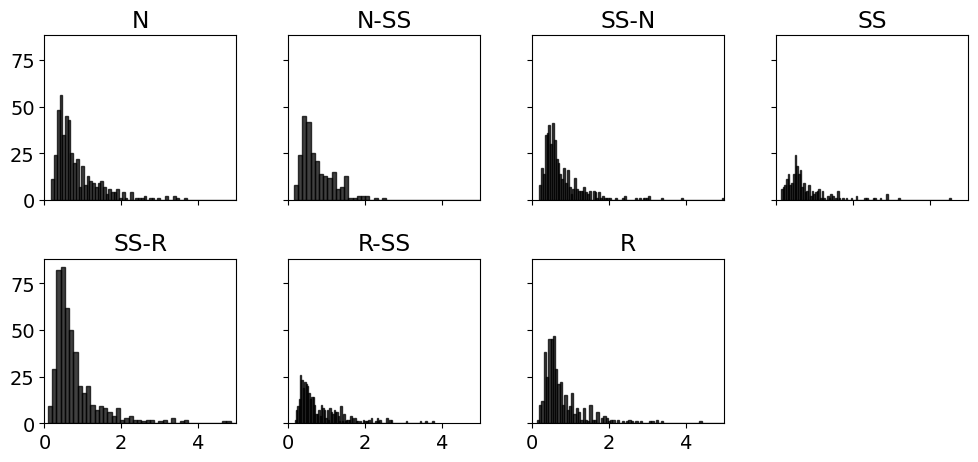

In [23]:
def classification_plot_N_Z_ratio(df_sta,ORIENTATION_OUTPUT=ORIENTATION_OUTPUT)

    # Create colors for each earthquake source
    classes = ['N','N-SS','SS-N','SS','SS-R','R-SS','R']
    colors = [mcolors.to_rgba(plt.cm.RdYlBu(each),alpha=0.5) for each in np.linspace(0, 1, len(classes))]
    color_map = dict(zip(classes, colors))
    
    # Create figure
    fig, axes = plt.subplots(2,4, figsize=(10, 5),sharex=True,sharey=True)
    axes = axes.flatten()
    
    # Subplot for each class
    for i in range(len(classes)):
        axes[i].set_title(classes[i])
    
        df_sta_class = df_sta[df_sta['event_class'] == classes[i]]
        ratio = df_sta_class['gain_HHN'] / df_sta_class['gain_HHZ']
        axes[i].hist(ratio, bins=100, color='k', edgecolor='k', alpha=0.75)
        axes[i].set_xlim(0,5)
    
    # Exclude last axis
    axes[-1].axis('off')
    
    # Final adjust
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    
    # Saving figure
    output_figure_CLASS = ORIENTATION_OUTPUT + 'EVENT_CLASS_FIGURES/'
    os.makedirs(output_figure_CLASS, exist_ok=True)
    fig.savefig(output_figure_CLASS + f'CLASS_HISTOGRAM_RZ_TOTAL.png',facecolor='w',dpi=300)